```text
01.EDA.ipynb
├── 1. Dataset Overview
├── 2. Class Distribution
│   ├── 2.1 Class Distribution Within Each Split
│   ├── 2.2 Class Imbalance per Split
│   └── 2.3 Metadata Availability
├── 3. Data Quality Checks
│   ├── 3.1 Corrupt Files
│   ├── 3.2 Duplicates
│   └── 3.3 Image Size Statistics & Aspect Ratio Analysis
│       └── Small Image Sizes & Extreme Aspect Ratios
├── 4. Intensity / Pixel Statistics
│   ├── 4.1 Per-Class Intensity / Pixel Distributions (Density Plots)
│   ├── 4.2 Statistically Underexposed / Overexposed Images
│   │   ├── Saturation Fractions
│   │   └── Robust Z-Scores
├── 5. Contrast Enhancement
│   ├── 5.1 Global Normalization
│   ├── 5.2 Contrast-limited adaptive histogram equalization (CLAHE)
│   ├── 5.3 Gamma Correction
│   ├── 5.3 Comparison of Mean Intensity and Contrast (Standard Deviation) Across Enhancement Methods
├── 6. BlackBorder Removal
│   ├── 6.1 Review BlackBorder from UnderExposed class 
│   ├── 6.2 Blackborder Removal Process
│   ├── 6.2 Visualize before and after removal 
│   ├── 6.2 Summary statistics of black border removal
└── 7. EDA conclusion


## 1. Dataset Overview

In [ ]:
import sys
from pathlib import Path
import cv2
import numpy as np

DATA_ROOT = "../data/raw/archive"
project_root = Path.cwd().parent
sys.path.append(str(project_root))

from src.utils.eda_utils import *
df = collect_metadata( DATA_ROOT, cache_path="../data/eda/metadata.csv", refresh=True)
print("Total images:", len(df))
df.head()

Metadata saved to ../data/eda/metadata.csv
Total images: 25553


path         filename  split  \
0  ../data/raw/archive/train/normal/normal-2125.jpg  normal-2125.jpg  train   
1  ../data/raw/archive/train/normal/normal-4554.jpg  normal-4554.jpg  train   
2  ../data/raw/archive/train/normal/normal-5892.jpg  normal-5892.jpg  train   
3  ../data/raw/archive/train/normal/normal-6343.jpg  normal-6343.jpg  train   
4  ../data/raw/archive/train/normal/normal-6425.jpg  normal-6425.jpg  train   

    label  
0  normal  
1  normal  
2  normal  
3  normal  
4  normal

In [ ]:

p = "/Users/lily/Documents/Projects/chest-xray/data/raw/archive/train/pneumonia/pneumonia-2796.jpg"
# /Users/lily/Documents/Projects/chest-xray/data/raw/archive/test/tuberculosis/tuberculosis-901.jpg
p= '/Users/lily/Documents/Projects/chest-xray/data/raw/archive/test/tuberculosis/tuberculosis-901.jpg'
image = cv2.imread( p , cv2.IMREAD_GRAYSCALE)
image1 = cv2.imread(p)
print(image1.shape)
c0 = image1[:, :, 0]
c1 = image1[:, :, 1]
c2 = image1[:, :, 2]
same_01 = np.array_equal(c0, c1)
same_02 = np.array_equal(c0, c2)
same_12 = np.array_equal(c1, c2)
print(same_01, same_02, same_12)

The dataset consists of chest X-ray images grouped into three clinically relevant categories: normal, pneumonia, and tuberculosis.

Images are pre-split into training, validation, and test sets, ensuring clear separation between model development and final evaluation. This predefined structure supports reproducible experiments and helps prevent data leakage.

## 2. Class Distribution ,  Imbalance and Meta data availability

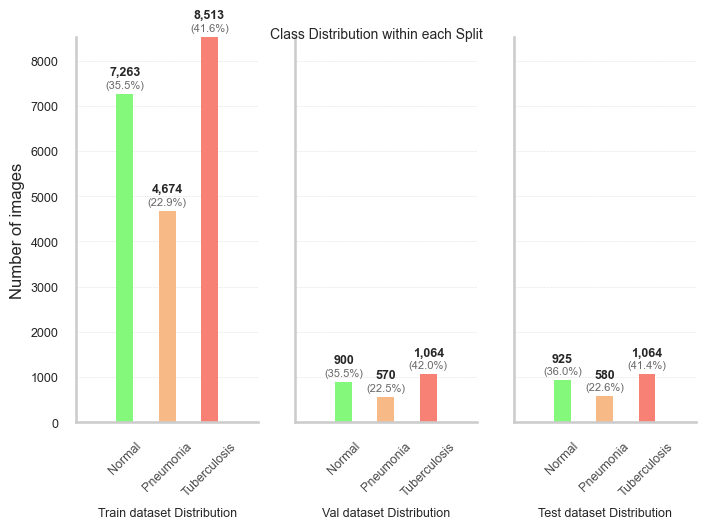

In [2]:
#2.1 Class Distribution within Each Split
CLASS_ORDER =["normal", "pneumonia", "tuberculosis"] #df.label.value_counts().keys().tolist()
CLASS_COLORS = { "normal": "#83F87B",  "pneumonia": "#F7B986",  "tuberculosis": "#F78174"}
SPLITS = ["train", "val", "test"]
distributions = {split: class_distribution(df, split) for split in SPLITS}
max_count = max( max(dist.values()) for dist in distributions.values())
fig, axes = plt.subplots( nrows=1, ncols=len(SPLITS), figsize=(8, 5),sharey=True)
for ax, split in zip(axes, SPLITS):
    plot_class_distribution(distributions[split], title=f"{split.capitalize()} dataset Distribution",
        ax=ax, class_order=CLASS_ORDER)
    ax.set_ylim(0, max_count)
    ax.tick_params(axis="x", labelsize=9)  
    ax.tick_params(axis="y", labelsize=9)  
axes[0].set_ylabel("Number of images" , fontsize=12)
fig.suptitle( "Class Distribution within each Split",fontsize=10, y=0.9)
#fig.savefig("class_distribution_split.png", dpi=300, bbox_inches="tight")
plt.show()

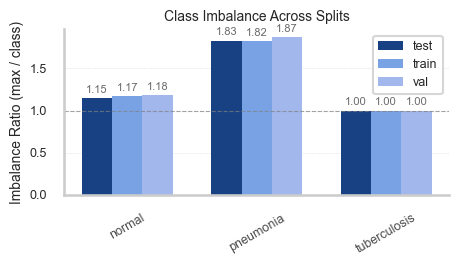

In [3]:
#2.2 Imbalance per Split (imbalance per class)  

#How many times rarer is this class than the majority?
#- Majority → 1.0
#- Minority → > 1.0

imb_df = (df.groupby(["split","label"]).size().reset_index(name="count")
          .assign(imbalance_ratio=lambda x: (x.groupby("split")["count"].transform("max") / x["count"]).round(2)))
plot_imbalance_ratio(imb_df, CLASS_ORDER, CLASS_COLORS)

In [4]:
# 2.3 Meta data availability
exif_df = inspect_exif_presence(df, max_samples=df.shape[0])
exif_summary = (exif_df.groupby(["split", "label"])
    .agg(exif_present=("has_exif", "mean"),
        avg_exif_tags=("num_exif_tags", "mean"),
        samples=("has_exif", "count") ).reset_index())
exif_summary["exif_present"] = (exif_summary["exif_present"] * 100).round(2)
exif_summary

100%|██████████| 25553/25553 [00:04<00:00, 5876.92it/s]


split         label  exif_present  avg_exif_tags  samples
0   test        normal           0.0            0.0      925
1   test     pneumonia           0.0            0.0      580
2   test  tuberculosis           0.0            0.0     1064
3  train        normal           0.0            0.0     7263
4  train     pneumonia           0.0            0.0     4674
5  train  tuberculosis           0.0            0.0     8513
6    val        normal           0.0            0.0      900
7    val     pneumonia           0.0            0.0      570
8    val  tuberculosis           0.0            0.0     1064

2.1) Class Distribution within Each Split
Class proportions are highly consistent across splits:
Normal: ~35–36%
Pneumonia: ~22–23%
Tuberculosis: ~41–42%
Absolute counts differ (train ≫ val/test), but relative composition is preserved.
This indicates proper stratified splitting and no split-induced class skew.

2.2) Tuberculosis is the majority class in all splits (imbalance ratio = 1.0).
Normal is mildly underrepresented (imbalance ≈ 1.15–1.18).
Pneumonia is the most underrepresented class (imbalance ≈ 1.82–1.87).
Imbalance ratios are nearly identical across train, val, and test, showing that imbalance is class-driven, not split-specific.

2.3) We checked EXIF (Exchangeable Image File Format) metadata in all 25,553 JPEG images across training, validation, and test sets but found none (zero EXIF tags).

### 3. Data Quality Check

In [7]:
### 3.1 Corrupt Files
corrupt_df = find_corrupt_images(df)
# 3.2 Duplicate Detection
df["filesize"] = df["path"].map(lambda p: Path(p).stat().st_size)
duplicate_df = df[df.duplicated(["filename", "filesize"], keep=False)]
print(f" Found {len(corrupt_df)} corrupt images")
print(f" Found {len(duplicate_df)} duplicate images")

 Found 0 corrupt images
 Found 0 duplicate images


In [8]:
### 3.3 Image Size Statistics & & aspect ratio analysis 
size_df = compute_size_flags(df, max_samples=df.shape[0]) 

100%|██████████| 25553/25553 [00:03<00:00, 7227.51it/s]


In [9]:
size_df.sample(4)

width  height  aspect_ratio         label  split  small_image  \
11895   1024    1024      1.000000        normal   test        False   
16740    256     256      1.000000  tuberculosis  train        False   
12094   1024    1024      1.000000  tuberculosis   test        False   
2414    1288     848      1.518868     pneumonia  train        False   

       extreme_aspect_ratio  
11895                 False  
16740                 False  
12094                 False  
2414                  False

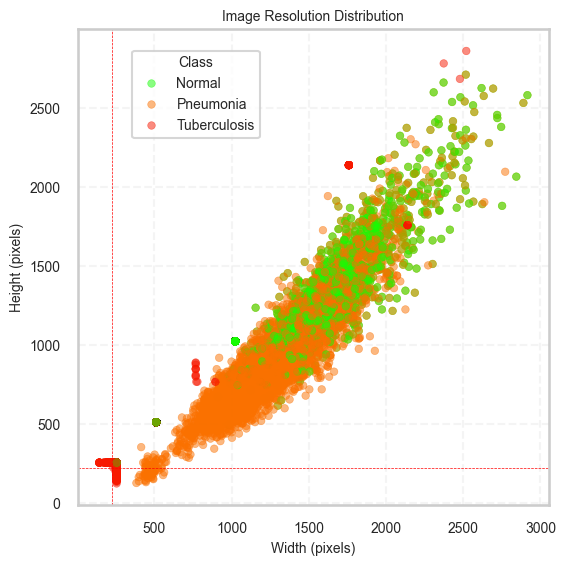

In [10]:
plot_size_distributions(size_df, CLASS_ORDER, save_path="image_resolution_distribution.png")

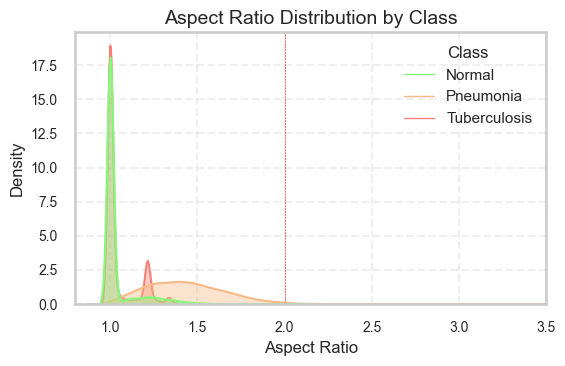

In [11]:
plot_aspect_ratio_distribution(size_df, CLASS_COLORS, classorder=CLASS_ORDER, save_path="aspect_ratio_distribution.png")

Aspect ratio analysis shows that most images are near-square (AR ≈ 1), with pneumonia images exhibiting slightly greater variability and extreme aspect ratios (AR > 2) occurring rarely across all classes.

/Users/lily/Documents/Projects/chest-xray/src/utils/eda_utils.py:182: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=size_df, x="label", y="aspect_ratio",


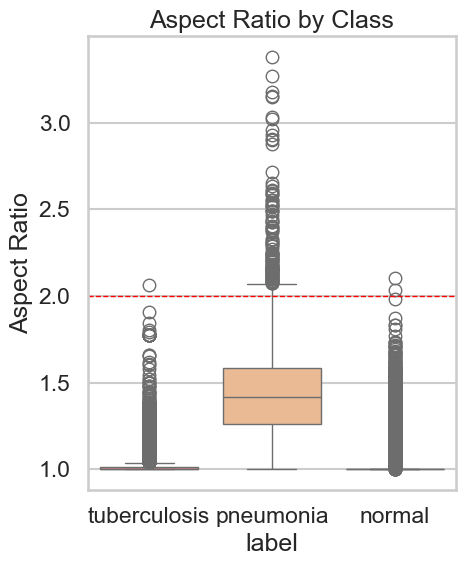

In [12]:
aspect_ratio_box_plot(size_df)

In [13]:
size_df["small_image"].mean() # 7.9% small_image

np.float64(0.07932532383673149)

In [14]:
(size_df.groupby("label")[["small_image", "extreme_aspect_ratio"]].mean().mul(100).round(2).style.format("{:.2f}").set_caption("Image Size Statistics by Label"))

3.1 & 3.2) A comprehensive data quality assessment was performed to identify corrupt files, duplicate images, and extreme image resolutions. No corrupt or unreadable images were detected across the dataset. 
Heuristic duplicate detection based on filename and file size revealed no duplicate samples, indicating strong dataset curation. 

3.3) Image size analysis showed that a non-trivial fraction of tuberculosis images (approximately 19%) have resolutions smaller than the target input size of 224 pixels, while extreme aspect ratios were rare across all classes. 

Importantly, removing small or extreme images would disproportionately affect specific classes and introduce dataset bias. 
Consequently, all images are retained, and resizing-based preprocessing is favored over dataset-level filtering.

### 4. Pixel intensity analysis

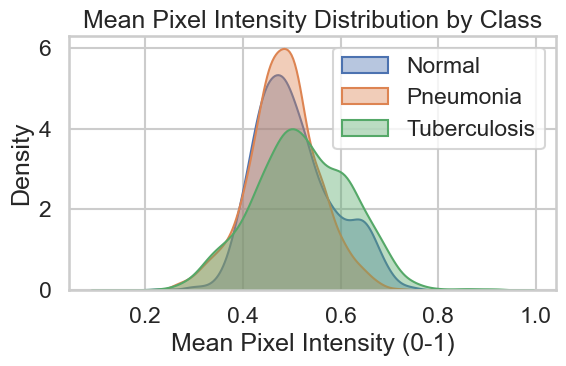

In [15]:
# 4.1 Intensity / pixel Per-class (Density plot)
plot_intensity_distribution_by_class(df, CLASS_ORDER)

In [ ]:
# 4.2 Statistically under/over -exposed
#Flag outliers 
# Saturation Fractions
from src.utils.image_utils import exposure_metrics, robust_z
exp = exposure_metrics(df, max_samples=df.shape[0])
exp["under_exposed"] = (exp.black_frac > 0.30) | (exp.p99 < 0.60) # 30% pixels black : under-exposed / heavy black borders
exp["over_exposed"]  = (exp.white_frac > 0.30) | (exp.p01 > 0.40) # 30% pixels white : over-exposed / washed out
exp[["under_exposed","over_exposed"]].mean().mul(100).round(2)
#exp.to_csv("exposure_metrics.csv", index=False)
summary = (exp.assign(under=exp.under_exposed, over=exp.over_exposed)
             .groupby(["split","label"])[["under_exposed","over_exposed"]]
             .mean().mul(100).round(2))
summary

under_exposed  over_exposed
split label                                    
test  normal                 1.84          0.00
      pneumonia              0.69          0.17
      tuberculosis           1.41          1.88
train normal                 1.82          0.00
      pneumonia              0.75          0.04
      tuberculosis           1.39          2.08
val   normal                 1.44          0.00
      pneumonia              1.05          0.00
      tuberculosis           2.07          2.54

In [ ]:
# Robust z-score
exp["z_mean"] = robust_z(exp["mean"].values)
exp["z_std"]  = robust_z(exp["std"].values)
exp["under_exposed_Z"] = (exp["z_mean"] < -3) | (exp["z_std"] < -3)
exp["over_exposed_Z"]  = (exp["z_mean"] >  3)

In [19]:
summary_z = exp.groupby(["split","label"])[["under_exposed_Z","over_exposed_Z"]].mean().mul(100).round(2)
summary_z

under_exposed_Z  over_exposed_Z
split label                                        
test  normal                   0.11            0.00
      pneumonia                0.17            0.17
      tuberculosis             1.32            0.94
train normal                   0.10            0.06
      pneumonia                0.09            0.04
      tuberculosis             1.07            1.14
val   normal                   0.22            0.00
      pneumonia                0.18            0.00
      tuberculosis             1.13            1.32

In [35]:
(over := exp['over_exposed_final'])
(under := exp['under_exposed_final'])
num_exposed = (over | under).sum()
total = len(exp)
num_exposed, total

(np.int64(639), 25553)

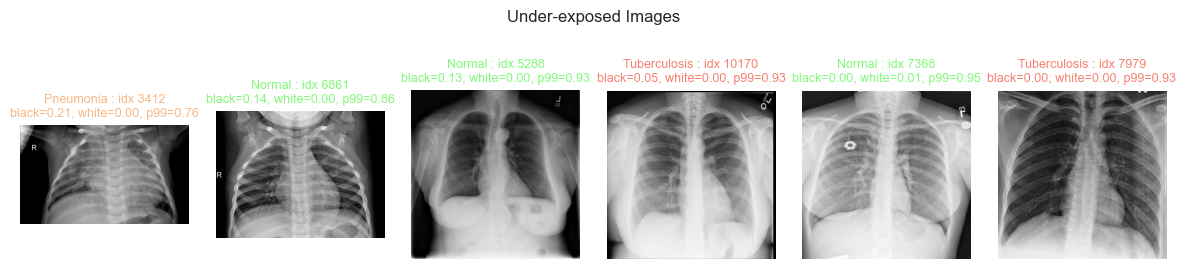

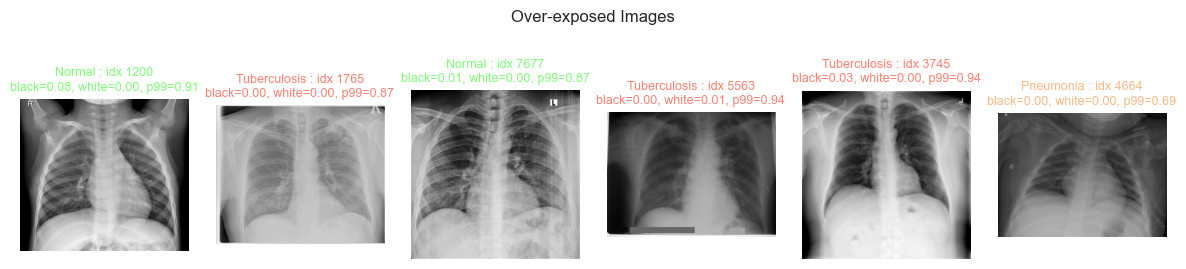

In [ ]:
viz_exposure_images(df[exp.under_exposed], exp, CLASS_COLORS, title="Under-exposed Images")
viz_exposure_images(df[exp.over_exposed], exp, CLASS_COLORS, title="Over-exposed Images")

In [21]:
exp["under_exposed_final"] = exp["under_exposed"] | exp["under_exposed_Z"]
exp["over_exposed_final"] = exp["over_exposed"] | exp["over_exposed_Z"]

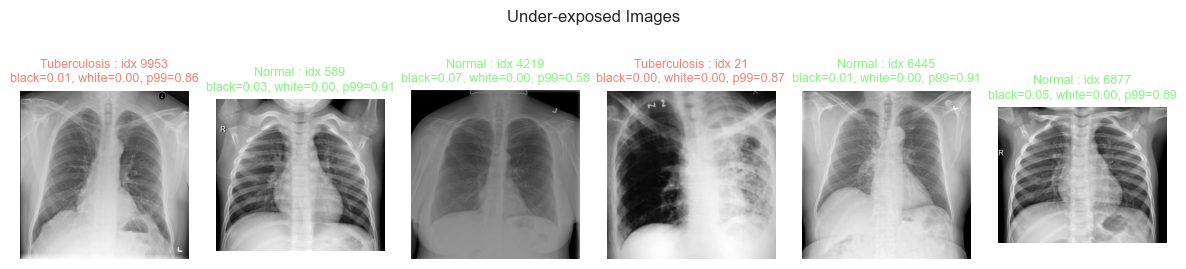

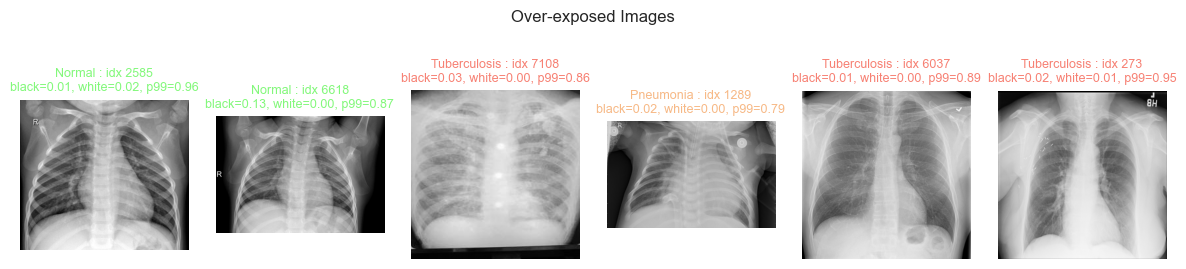

In [22]:
viz_exposure_images(df[exp.under_exposed_final], exp, CLASS_COLORS, title="Under-exposed Images")
viz_exposure_images(df[exp.over_exposed_final], exp, CLASS_COLORS, title="Over-exposed Images")

In [30]:
under_total = exp["under_exposed"].sum()
under_z_total = (exp["under_exposed_Z"] > 0).sum()
under_overlap = exp["under_exposed_final"].sum()
over_total = exp["over_exposed"].sum()
over_z_total = (exp["over_exposed_Z"] > 0).sum()
over_overlap = exp["over_exposed_final"].sum()
print(f"Under-exposed: intensity={under_total}, z-score={under_z_total}, overlap={under_overlap}")
print(f"Over-exposed: intensity={over_total}, z-score={over_z_total}, overlap={over_overlap}")

Under-exposed: intensity=362, z-score=133, overlap=474
Over-exposed: intensity=227, z-score=128, overlap=248


### 5. Contrast Enhancement


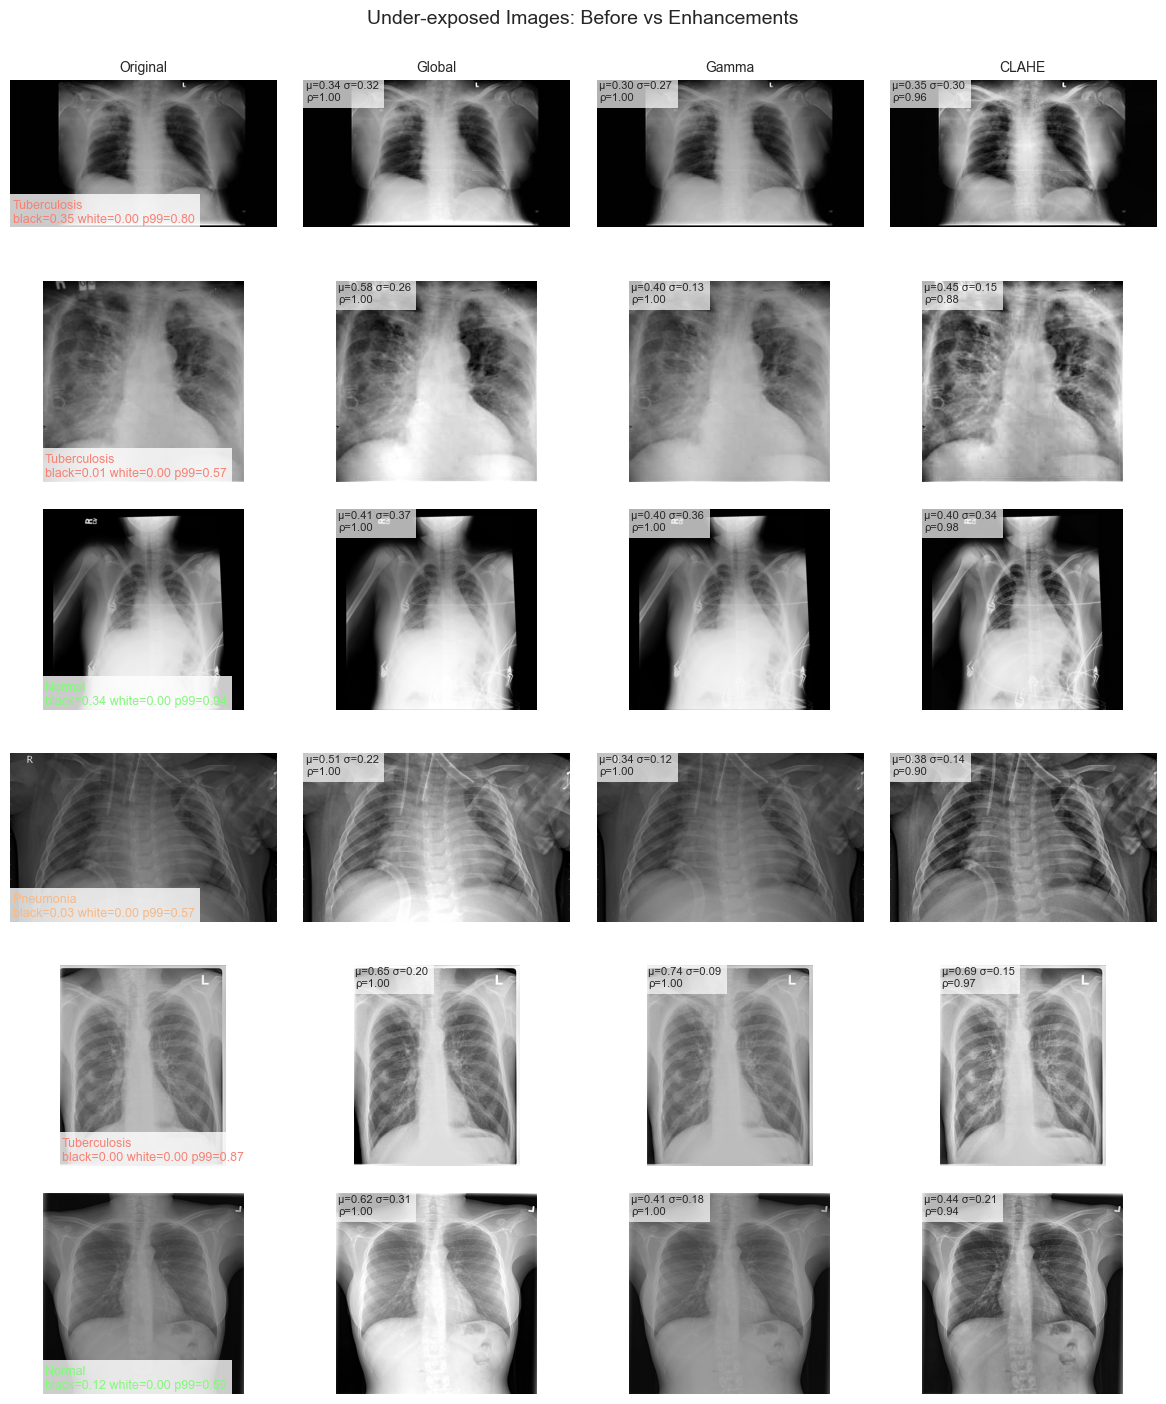

In [ ]:
# Comparison of Mean Intensity and Contrast (Standard Deviation) Across Enhancement Methods
# Global Normalization  vs  Contrast-limited adaptive histogram equalization (CLAHE) vs Gamma Correction
under_df = exp[exp["under_exposed_final"]].sample(6, random_state=42)
visualize_exposure_set(under_df, "Under-exposed Images: Before vs Enhancements" , CLASS_COLORS)

In [45]:
exp['mean'].describe()

count    25553.000000
mean         0.506450
std          0.090024
min          0.021327
25%          0.446252
50%          0.497829
75%          0.562805
max          0.970127
Name: mean, dtype: float64

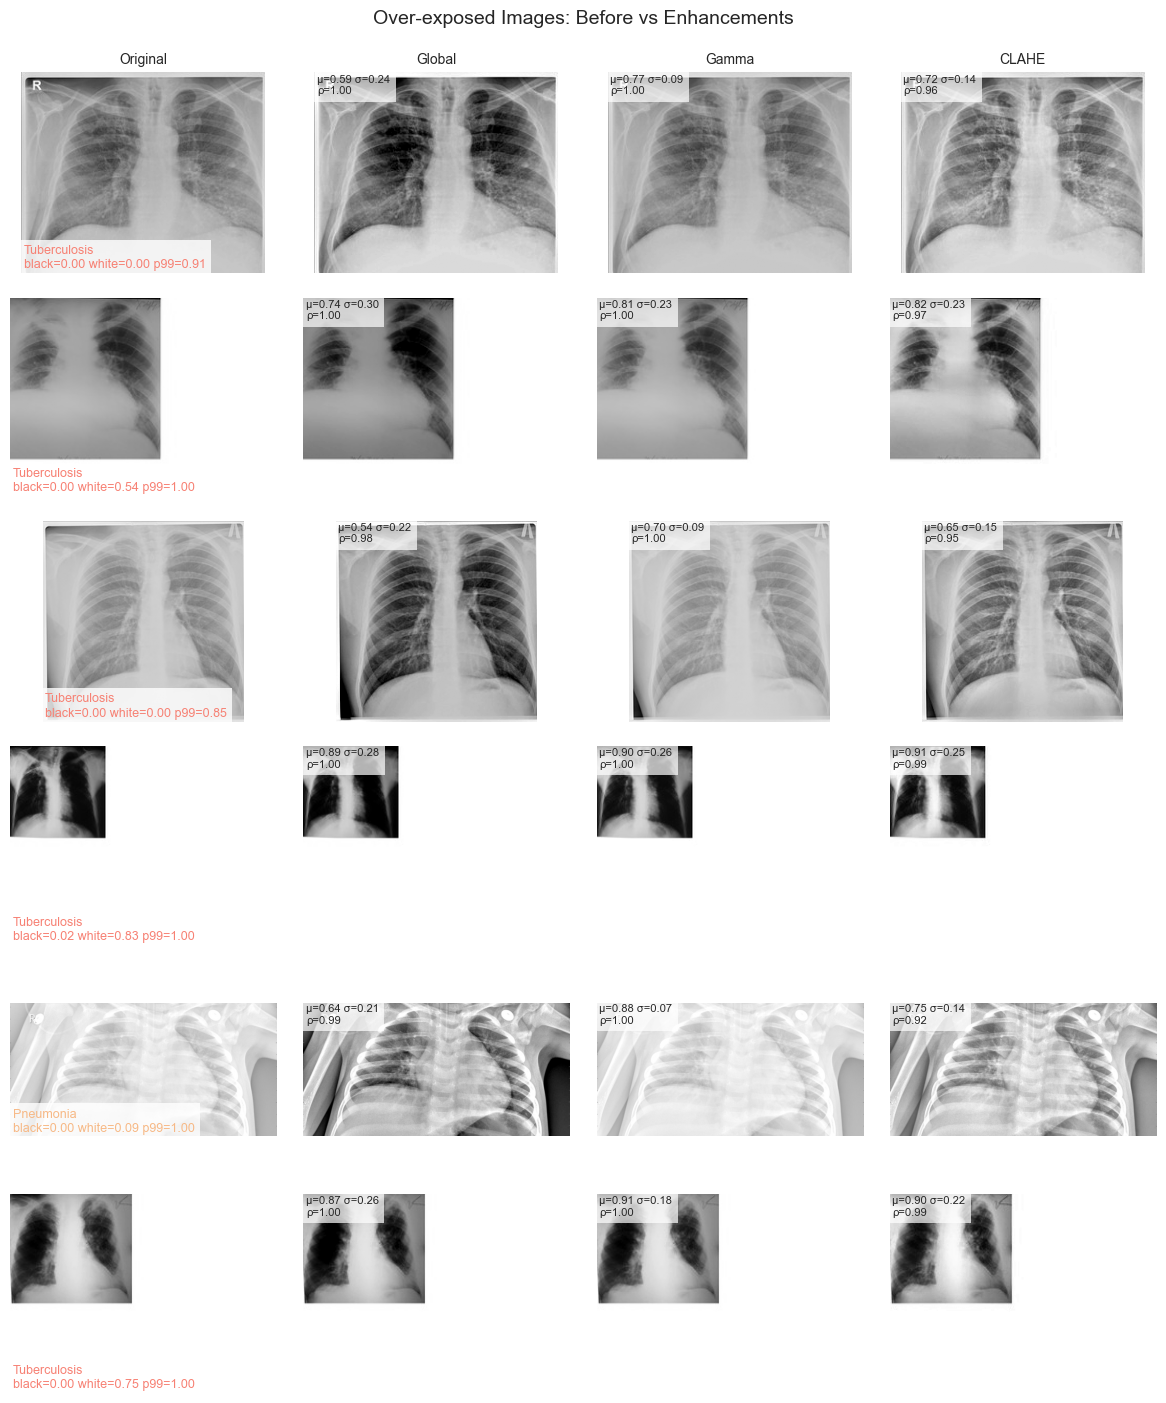

In [32]:
over_df  = exp[exp["over_exposed_final"]].sample(6, random_state=7)
visualize_exposure_set(over_df,  "Over-exposed Images: Before vs Enhancements", CLASS_COLORS)

Findings

Only ~2% of images were statistically flagged as under- or over-exposed => Good quality dataset.
Quantitative analysis (p99, black_frac, white_frac) identifies subtle dynamic-range compression that is not visually obvious.
Tuberculosis images show the highest exposure instability, both under- and over-exposed.
Contrast-limited adaptive histogram equalization (CLAHE) significantly improves local contrast while preserving anatomical structure (ρ≈0.88–0.99). Therefore, CLAHE is adopted as a conditional preprocessing step for low-contrast images rather than a global transform.

## 6. BlackBorder Removal

In [36]:
# 6.1 Review BlackBorder from UnderExposed class 
from src.utils.image_utils import (border_black_ratio, has_black_borders, load_gray)
black_border = exp[exp["under_exposed_final"]].copy()
black_border.reset_index(drop=True, inplace=True)
ratios = []
flags = []
for p in black_border["path"]:
    img = load_gray(p)
    ratios.append(border_black_ratio(img))
    flags.append(has_black_borders(img))
black_border["black_border_ratio"] = ratios
black_border["has_black_borders"] = flags
black_border['has_black_borders'].value_counts()
black_border_true = black_border[black_border["has_black_borders"]]

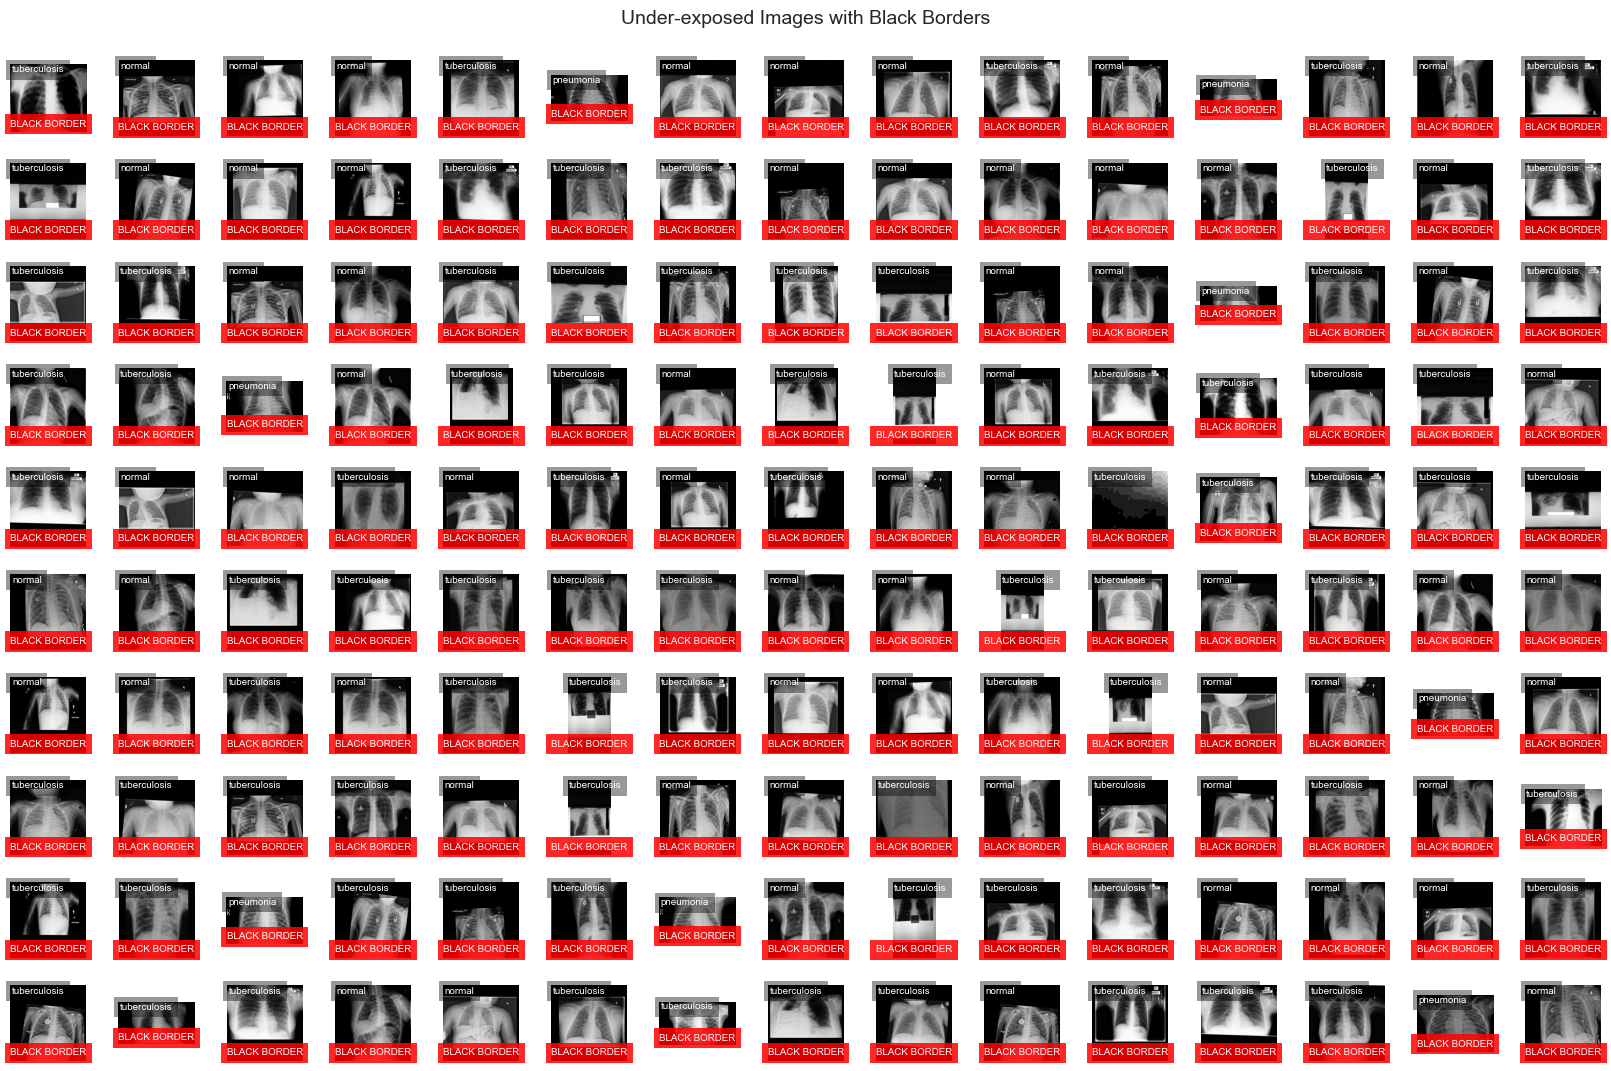

In [37]:
# Blackborder Removal Process
# Visualize before and after removal 
viz_blackborder(black_border_true,
    "Under-exposed Images with Black Borders",
    n_cols=15, thumb_size=1.1,
    flag_col="has_black_borders",flag_text="BLACK BORDER")

img shape (228, 256) cropped img shape (228, 256) 
img shape (1024, 1024) cropped img shape (637, 976) 
img shape (1024, 1024) cropped img shape (713, 859) 
img shape (512, 512) cropped img shape (500, 451) 
img shape (512, 512) cropped img shape (462, 439) 
img shape (817, 1352) cropped img shape (817, 1349) 
img shape (512, 512) cropped img shape (343, 512) 
img shape (512, 512) cropped img shape (346, 467) 
img shape (512, 512) cropped img shape (350, 453) 
img shape (256, 256) cropped img shape (203, 256) 
img shape (512, 512) cropped img shape (486, 421) 
img shape (560, 1160) cropped img shape (560, 1160) 
img shape (512, 512) cropped img shape (478, 414) 
img shape (1024, 1024) cropped img shape (1024, 1024) 
img shape (256, 256) cropped img shape (188, 256) 
img shape (512, 512) cropped img shape (260, 512) 
img shape (512, 512) cropped img shape (461, 426) 
img shape (512, 512) cropped img shape (357, 441) 
img shape (1024, 1024) cropped img shape (704, 772) 
img shape (256, 2

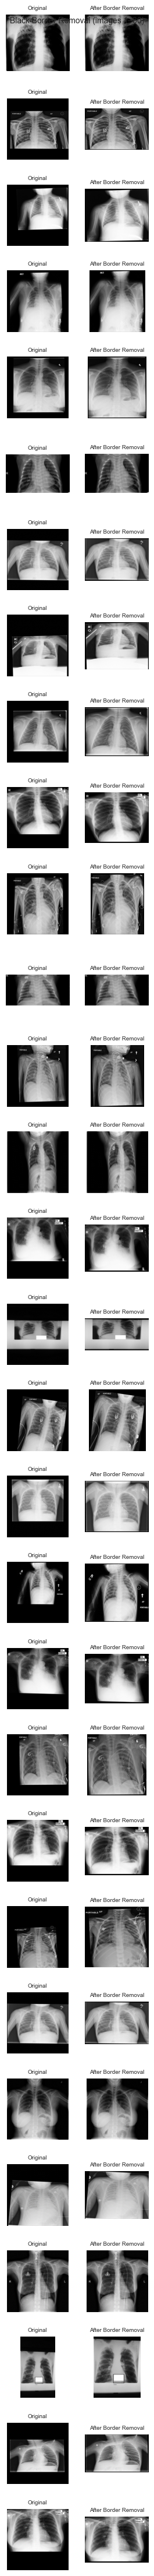

img shape (512, 512) cropped img shape (290, 510) 
img shape (256, 256) cropped img shape (189, 223) 
img shape (512, 512) cropped img shape (323, 491) 
img shape (1024, 1024) cropped img shape (1024, 1024) 
img shape (512, 512) cropped img shape (343, 512) 
img shape (512, 512) cropped img shape (370, 512) 
img shape (512, 512) cropped img shape (486, 421) 
img shape (2140, 1760) cropped img shape (1734, 1526) 
img shape (512, 512) cropped img shape (460, 512) 
img shape (1024, 1024) cropped img shape (699, 732) 
img shape (512, 512) cropped img shape (512, 512) 
img shape (720, 1584) cropped img shape (720, 1584) 
img shape (1024, 1024) cropped img shape (1005, 1024) 
img shape (1024, 1024) cropped img shape (916, 844) 
img shape (256, 256) cropped img shape (180, 256) 
img shape (512, 512) cropped img shape (512, 512) 
img shape (512, 512) cropped img shape (512, 512) 
img shape (856, 1280) cropped img shape (856, 1280) 
img shape (1024, 1024) cropped img shape (1024, 1024) 
img sha

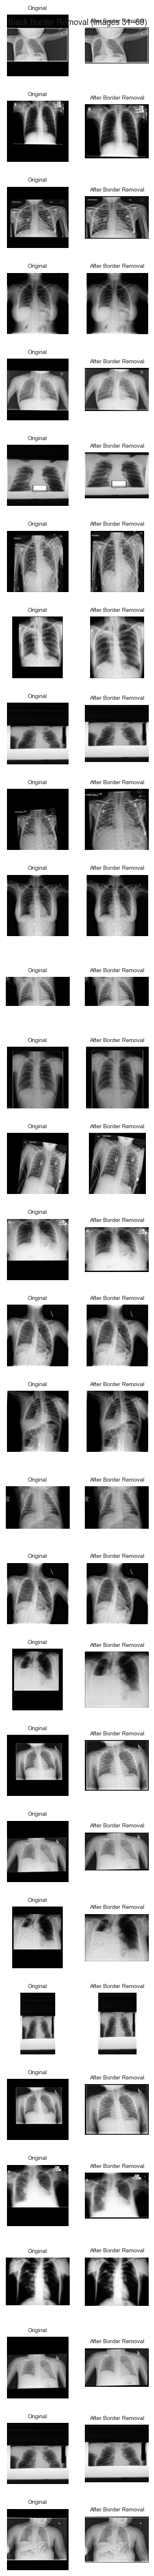

img shape (256, 256) cropped img shape (184, 256) 
img shape (1024, 1024) cropped img shape (575, 1018) 
img shape (512, 512) cropped img shape (383, 507) 
img shape (1024, 1024) cropped img shape (980, 1024) 
img shape (1024, 1024) cropped img shape (546, 919) 
img shape (256, 256) cropped img shape (238, 210) 
img shape (1024, 1024) cropped img shape (619, 781) 
img shape (256, 256) cropped img shape (162, 180) 
img shape (512, 512) cropped img shape (478, 414) 
img shape (1024, 1024) cropped img shape (905, 1024) 
img shape (256, 256) cropped img shape (12, 8) 
img shape (211, 256) cropped img shape (211, 256) 
img shape (256, 256) cropped img shape (196, 256) 
img shape (512, 512) cropped img shape (364, 501) 
img shape (512, 512) cropped img shape (257, 512) 
img shape (1024, 1024) cropped img shape (855, 824) 
img shape (1024, 1024) cropped img shape (1024, 1024) 
img shape (512, 512) cropped img shape (335, 463) 
img shape (512, 512) cropped img shape (362, 435) 
img shape (1024

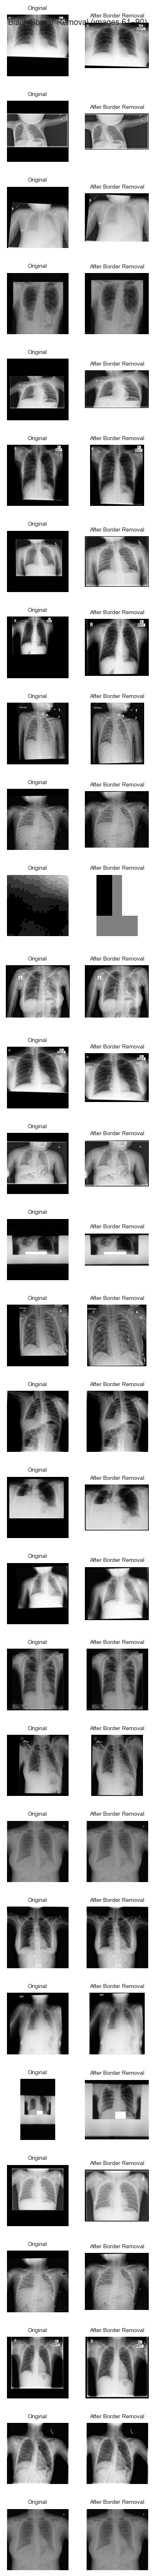

img shape (512, 512) cropped img shape (357, 391) 
img shape (512, 512) cropped img shape (462, 439) 
img shape (512, 512) cropped img shape (512, 512) 
img shape (1024, 1024) cropped img shape (913, 868) 
img shape (1024, 1024) cropped img shape (1005, 1024) 
img shape (256, 144) cropped img shape (205, 144) 
img shape (256, 256) cropped img shape (191, 211) 
img shape (1024, 1024) cropped img shape (703, 871) 
img shape (512, 512) cropped img shape (362, 435) 
img shape (512, 512) cropped img shape (500, 451) 
img shape (256, 144) cropped img shape (134, 144) 
img shape (512, 512) cropped img shape (290, 510) 
img shape (1024, 1024) cropped img shape (952, 819) 
img shape (736, 1322) cropped img shape (736, 1015) 
img shape (1024, 1024) cropped img shape (689, 896) 
img shape (512, 512) cropped img shape (455, 512) 
img shape (512, 512) cropped img shape (383, 507) 
img shape (512, 512) cropped img shape (323, 491) 
img shape (512, 512) cropped img shape (512, 512) 
img shape (512, 5

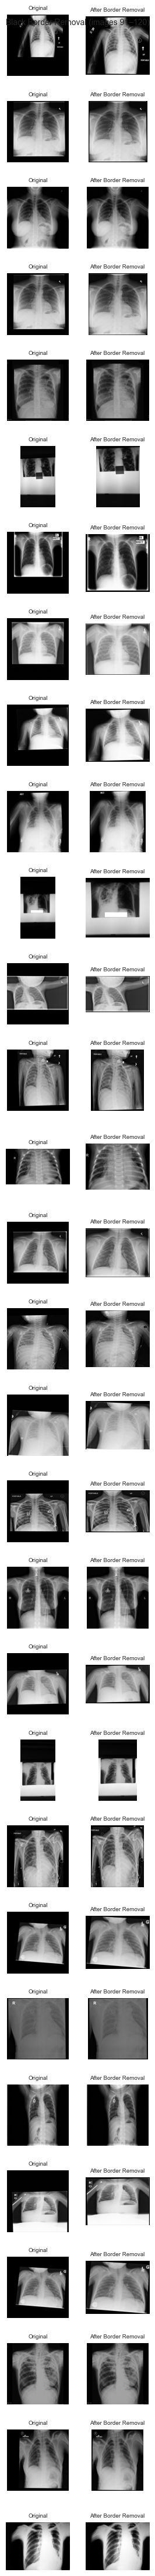

img shape (512, 512) cropped img shape (357, 391) 
img shape (1024, 1024) cropped img shape (1024, 1024) 
img shape (824, 1352) cropped img shape (824, 1352) 
img shape (512, 512) cropped img shape (461, 426) 
img shape (512, 512) cropped img shape (352, 370) 
img shape (512, 512) cropped img shape (512, 512) 
img shape (832, 1392) cropped img shape (832, 1392) 
img shape (1024, 1024) cropped img shape (1024, 1024) 
img shape (256, 144) cropped img shape (221, 144) 
img shape (512, 512) cropped img shape (278, 464) 
img shape (256, 256) cropped img shape (198, 256) 
img shape (1024, 1024) cropped img shape (780, 896) 
img shape (1024, 1024) cropped img shape (988, 831) 
img shape (1024, 1024) cropped img shape (685, 923) 
img shape (1024, 1024) cropped img shape (1024, 1024) 
img shape (512, 512) cropped img shape (390, 452) 
img shape (142, 256) cropped img shape (142, 189) 
img shape (256, 256) cropped img shape (188, 256) 
img shape (512, 512) cropped img shape (512, 512) 
img shape

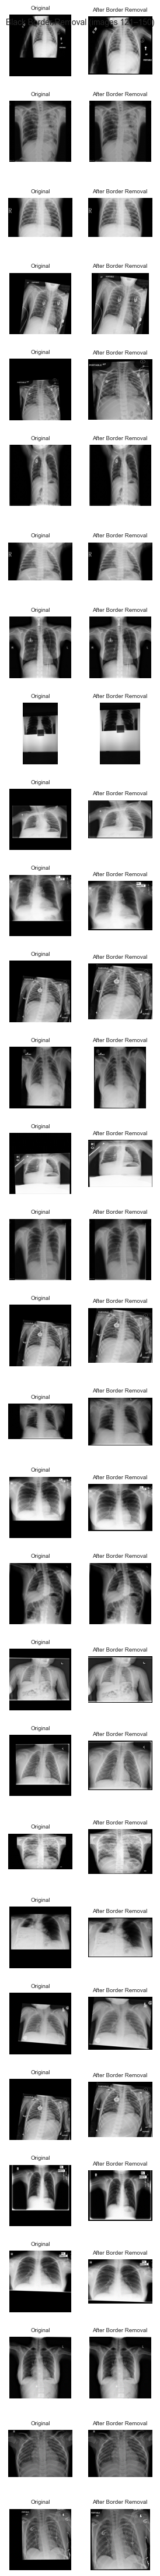

In [38]:
stats_df = visualize_black_border_removal(black_border_true, n_per_page=30, thumb_height=1.5, thumb_width=1.5)

In [39]:
stats_df

before     after  reduction_pct
0   0.675510  0.390609      42.175597
1   0.312289  0.312289       0.000000
2   0.311234  0.311234       0.000000
3   0.401024  0.200462      50.012238
4   0.606396  0.207763      65.738009
5   0.469276  0.469276       0.000000
6   0.301715  0.301715       0.000000
7   0.313299  0.313299       0.000000
8   0.447917  0.360483      19.520108
9   0.537914  0.060926      88.673447
10  0.319412  0.120048      62.415728
11  0.439751  0.159421      63.747315
12  0.351042  0.171183      51.235588
13  0.420861  0.039516      90.610538
14  0.311901  0.311901       0.000000
15  0.439014  0.165765      62.241489
16  0.350902  0.120799      65.574598
17  0.342331  0.104451      69.488201
18  0.306889  0.306889       0.000000
19  0.333183  0.041467      87.554180
20  0.432175  0.061167      85.846537
21  0.353109  0.192175      45.576181
22  0.486176  0.096461      80.159087
23  0.518105  0.170915      67.011326
24  0.439014  0.165765      62.241489
25  0.517090  0.342925      33.681603
26  0.391556  0.124934      68.092709
27  0.335434  0.335434       0.000000
28  0.141551  0.141551       0.000000
29  0.361637  0.062242      82.788727

In [52]:
def plot_black_border_reduction(stats_df, save_path, bins=20):
    plt.figure(figsize=(5, 4))
    plt.hist(stats_df['reduction_pct'], bins=bins, color='skyblue', edgecolor='black')
    plt.xlabel("Black Border Reduction (%)", fontsize=10)
    plt.ylabel("Number of Images", fontsize=10)
    plt.title("Distribution of Black Border Removal", fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


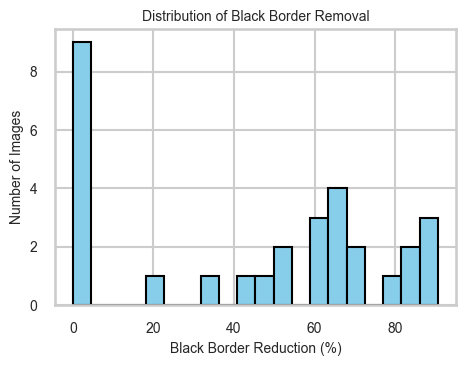

In [53]:
# Summary statistics of black border removal
plot_black_border_reduction(stats_df, "black_border_reduction.png")

In [41]:
black_border_true.to_csv('../data/eda/black_border_removal_stats.csv', index=False)

In [42]:
black_border_true

path         label  split  \
6    ../data/raw/archive/train/tuberculosis/tubercu...  tuberculosis  train   
7     ../data/raw/archive/train/normal/normal-1898.jpg        normal  train   
8     ../data/raw/archive/train/normal/normal-2249.jpg        normal  train   
9     ../data/raw/archive/train/normal/normal-3969.jpg        normal  train   
15   ../data/raw/archive/train/tuberculosis/tubercu...  tuberculosis  train   
..                                                 ...           ...    ...   
461  ../data/raw/archive/train/tuberculosis/tubercu...  tuberculosis  train   
463  ../data/raw/archive/val/tuberculosis/tuberculo...  tuberculosis    val   
471  ../data/raw/archive/val/tuberculosis/tuberculo...  tuberculosis    val   
472  ../data/raw/archive/test/pneumonia/pneumonia-5...     pneumonia   test   
473   ../data/raw/archive/train/normal/normal-1698.jpg        normal  train   

         mean       std  p01       p99  black_frac  white_frac  under_exposed  \
6    0.304301  0.272891  0.0  0.796078    0.308405    0.000000           True   
7    0.232720  0.266090  0.0  0.835294    0.453760    0.000847           True   
8    0.292402  0.370718  0.0  0.984314    0.538474    0.068805           True   
9    0.386524  0.350835  0.0  0.937255    0.342762    0.002071           True   
15   0.391312  0.329017  0.0  0.870588    0.313774    0.000397           True   
..        ...       ...  ...       ...         ...         ...            ...   
461  0.229656  0.309022  0.0  0.984314    0.517090    0.039795           True   
463  0.359564  0.358200  0.0  0.984314    0.391556    0.063507           True   
471  0.302982  0.286078  0.0  0.858824    0.335434    0.000866           True   
472  0.287752  0.160118  0.0  0.533333    0.141551    0.000448           True   
473  0.286991  0.253575  0.0  0.807843    0.361637    0.001339           True   

     over_exposed    z_mean     z_std  under_exposed_Z  over_exposed_Z  \
6           False -2.281767  0.881416            False           False   
7           False -3.125736  0.733391             True           False   
8           False -2.422064  3.010780            False           False   
9           False -1.312331  2.578002            False           False   
15          False -1.255874  2.103094            False           False   
..            ...       ...       ...              ...             ...   
461         False -3.161862  1.667864             True           False   
463         False -1.630202  2.738301            False           False   
471         False -2.297326  1.168459            False           False   
472         False -2.476896 -1.573272            False           False   
473         False -2.485868  0.460982            False           False   

     under_exposed_final  over_exposed_final  black_border_ratio  \
6                   True               False            0.408419   
7                   True               False            0.884778   
8                   True               False            0.976172   
9                   True               False            0.817285   
15                  True               False            0.930664   
..                   ...                 ...                 ...   
461                 True               False            0.773340   
463                 True               False            0.621680   
471                 True               False            0.680103   
472                 True               False            0.555882   
473                 True               False            0.718335   

     has_black_borders  
6                 True  
7                 True  
8                 True  
9                 True  
15                True  
..                 ...  
461               True  
463               True  
471               True  
472               True  
473               True  

[150 rows x 19 columns]

## EDA Conclusion

The dataset is well structured and free of integrity issues, with no corrupt or duplicate images and consistent class distributions across training, validation, and test splits. 
Class proportions are stable, indicating correct stratification, although moderate class imbalance is present, particularly for Pneumonia, which necessitates class-aware training and macro-averaged evaluation metrics. 
No usable metadata was available, and modeling therefore relies exclusively on image-based features.

Geometric analysis reveals substantial variability in image resolution and aspect ratio across classes. 
Tuberculosis images contain a high proportion of very small samples, while Pneumonia images exhibit more extreme aspect ratios, indicating heterogeneous acquisition sources. 
=> To avoid anatomical distortion and resolution loss, images must be resized using aspect-ratio–preserving strategies with padding rather than aggressive cropping.

Photometric analysis shows that mean pixel intensity distributions largely overlap across classes, but Tuberculosis images display greater variance and a higher frequency of exposure outliers. 
Although only approximately two percent of images are statistically flagged as under- or over-exposed, quantitative metrics reveal subtle dynamic-range compression that is not always visually apparent. 
This introduces a risk of class-correlated photometric bias if left uncorrected.

Contrast-limited adaptive histogram equalization improves local contrast while preserving anatomical structure, as indicated by high structural correlation with original images. Consequently, CLAHE will be applied conditionally to low-contrast images rather than globally. 
Black border artifacts are concentrated within underexposed images and, when present, are severe and non-anatomical. 
These borders reduce effective lung resolution and can act as spurious cues, particularly for attention-based models. 
Therefore, black border removal will be applied to all images identified as underexposed to eliminate frame artifacts and improve spatial consistency.

Overall, the dataset is suitable for supervised classification provided that class imbalance is addressed, geometric consistency is enforced, exposure-related artifacts are corrected selectively, and evaluation focuses on class-aware performance metrics. These preprocessing decisions directly inform model robustness and reduce the risk of learning non-pathological shortcuts.